## Appendix: Exploratory Data Analysis (EDA) and Preprocessing

## Team 2 - Shpaner, Leonid; Oakes, Isabella, Lucban, Emanuel

**Loading the requisite libraries**

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply
import random

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, \
StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge, LogisticRegression

# Enable Experimental
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn import tree

import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
classification_report,accuracy_score

from sklearn import linear_model
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

**Reading in and Inspecting the dataframe**

In [2]:
coupons_df = pd.read_csv('https://archive.ics.uci.edu/ml/\
machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv')
coupons_df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [3]:
coupons_df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object

In [4]:
null_vals = pd.DataFrame(coupons_df.isna().sum(), columns=['Null Count'])
null_vals['Null Percent'] = (null_vals['Null Count'] / coupons_df.shape[0]) * 100
null_vals

,Null Count,Null Percent
destination,0,0.000000
passanger,0,0.000000
weather,0,0.000000
temperature,0,0.000000
time,0,0.000000
coupon,0,0.000000
expiration,0,0.000000
gender,0,0.000000
age,0,0.000000
maritalStatus,0,0.000000


### EDA - Discovery

**Renaming Columns**

In [5]:
# Renaming the passanger column to 'passenger'
coupons_df = coupons_df.rename(columns={'passanger':'passenger'})

# Renaming the 'Y' column as our Target
coupons_df = coupons_df.rename(columns={'Y':'Target'})

# Binarizing Target Variable
coupons_df['Target'] = coupons_df['Target'].map({1 : 'yes', 0 : 'no'})

# Creating a new column of dummy var. for Binary Target (Response)
coupons_df['Response'] = coupons_df['Target'].map({'yes':1, 'no':0})

**Removing Highly Correlated Predictors**

In [6]:
correlation_matrix = coupons_df.corr()
correlated_features = set()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(correlated_features)

{'direction_opp'}


**Mapping Important Categorical Features to Numerical Ones**

In [7]:
print(coupons_df['education'].unique())

['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']


In [8]:
coupons_df['educ. level'] = coupons_df['education'].map(\
                            {'Some High School':1, 
                             'Some college - no degree':2, 
                             'Bachelors degree':3, 'Associates degree':4, 
                             'High School Graduate':5, 
                             'Graduate degree (Masters or Doctorate)':6})

In [9]:
# create new variable 'avg_income' based on income
inc = coupons_df['income'].str.findall('(\d+)')
coupons_df['avg_income'] = pd.Series([])

for i in range(0,len(inc)):
    inc[i] = np.array(inc[i]).astype(np.float)
    coupons_df['avg_income'][i] = sum(inc[i]) / len(inc[i])

print(coupons_df['avg_income'])

0        43749.5
1        43749.5
2        43749.5
3        43749.5
4        43749.5
          ...   
12679    81249.5
12680    81249.5
12681    81249.5
12682    81249.5
12683    81249.5
Name: avg_income, Length: 12684, dtype: float64


In [10]:
# Creating new age range column
print(coupons_df['age'].value_counts())
coupons_df['Age Range'] = coupons_df['age'].map({'below21':'21 and below', 
                                                 '21':'21-25','26':'26-30',
                                                 '31':'31-35','36':'36-40', 
                                                 '41':'41-45','46':'46-50',
                                                 '50plus':'50+'})

21         2653
26         2559
31         2039
50plus     1788
36         1319
41         1093
46          686
below21     547
Name: age, dtype: int64


In [11]:
# Creating new age group column based on ordinal values
print(coupons_df['age'].value_counts())
coupons_df['Age Group'] = coupons_df['age'].map({'below21':1, 
                                                 '21':2,'26':3,
                                                 '31':4,'36':5, 
                                                 '41':6,'46':6,
                                                 '50plus':7})

21         2653
26         2559
31         2039
50plus     1788
36         1319
41         1093
46          686
below21     547
Name: age, dtype: int64


In [12]:
# Numericizing Age variable by adding new column: 'ages'
coupons_df['ages'] = coupons_df['age'].map({'below21':20, 
                                            '21':21,'26':26,
                                            '31':31,'36':36,
                                            '41':41,'46':46,
                                            '50plus':65})

In [13]:
# Changing coupon expiration to uniform # of hours
coupons_df['expiration'] = coupons_df['expiration'].map({'1d':24, '2h':2})

In [14]:
# Convert time to 24h military time
def convert_time(x):
    if x[-2:] == "AM":
        return int(x[0:-2]) % 12
    else:
        return (int(x[0:-2]) % 12) + 12
          
coupons_df['time'] = coupons_df['time'].apply(convert_time)

### Selected Features by Target Response

In [15]:
print("\033[1m"+'Target Outcome by Age (Maximum Values):'+"\033[1m")

def target_by_age():
    target_yes = coupons_df.loc[coupons_df.Target == 'yes'].groupby(
                               ['Age Range'])[['Target']].count()
    target_yes.rename(columns={'Target':'Yes'}, inplace=True)

    target_no = coupons_df.loc[coupons_df.Target == 'no'].groupby(
                               ['Age Range'])[['Target']].count()
    target_no.rename(columns={'Target':'No'}, inplace=True)

    target_age = pd.concat([target_yes, target_no], axis = 1)
    target_age['Yes'] = target_age['Yes'].fillna(0)
    target_age['No'] = target_age['No'].fillna(0)
    target_age
    max = target_age.max()
    print(max)
    target_age.loc['Total'] = target_age.sum(numeric_only=True, axis=0)
    target_age['% of Total'] = round((target_age['Yes'] / (target_age['Yes'] \
                                                + target_age['No']))* 100, 2)
    return target_age.style.format("{:,.0f}")

target_by_age()

Target Outcome by Age (Maximum Values):
Yes    1587
No     1066
dtype: int64


,Yes,No,% of Total
Age Range,,,
21 and below,347,200,63
21-25,"1,587","1,066",60
26-30,"1,525","1,034",60
31-35,"1,114",925,55
36-40,706,613,54
41-45,626,467,57
46-50,395,291,58
50+,910,878,51
Total,"7,210","5,474",57


In [16]:
print("\033[1m"+'Target Outcome by Income (Maximum Values):'+"\033[1m")

def target_by_income():
    target_yes = coupons_df.loc[coupons_df.Target == 'yes'].\
    groupby(['avg_income'])[['Target']].count()
    target_yes.rename(columns={'Target':'Yes'}, inplace=True)

    target_no = coupons_df.loc[coupons_df.Target == 'no'].\
    groupby(['avg_income'])[['Target']].count()
    target_no.rename(columns={'Target':'No'}, inplace=True)

    target_inc = pd.concat([target_yes, target_no], axis = 1)
    target_inc['Yes'] = target_inc['Yes'].fillna(0)
    target_inc['No'] = target_inc['No'].fillna(0)
    target_inc
    max = target_inc.max()
    print(max)
    target_inc.loc['Total'] = target_inc.sum(numeric_only=True, axis=0)
    target_inc['% of Total'] = round((target_inc['Yes'] / (target_inc['Yes'] \
                                    + target_inc['No']))* 100, 2)
    return target_inc.style.format("{:,.0f}")

target_by_income()

Target Outcome by Income (Maximum Values):
Yes    1194
No      819
dtype: int64


,Yes,No,% of Total
avg_income,,,
12500.0,618,424,59
18749.5,"1,052",779,57
31249.5,"1,194",819,59
43749.5,"1,018",787,56
56249.5,988,671,60
68749.5,446,400,53
81249.5,414,443,48
93749.5,476,419,53
100000.0,"1,004",732,58


### Selected Features' Value Counts

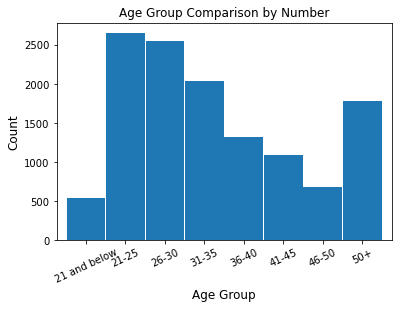

21 and below     547
21-25           2653
26-30           2559
31-35           2039
36-40           1319
41-45           1093
46-50            686
50+             1788
Name: Age Range, dtype: int64

In [17]:
age_count = coupons_df['Age Range'].value_counts().reindex(["21 and below", 
                                             "21-25", "26-30", 
                                             "31-35","36-40", 
                                             "41-45", "46-50",
                                             "50+"])
fig = plt.figure()
age_count.plot.bar(x ='lab', y='val', rot=0, width=0.98)
plt.title ('Age Group Comparison by Number', fontsize=12)
plt.xlabel('Age Group', fontsize=12) 
plt.ylabel('Count', fontsize=12); plt.xticks(rotation = 25)
plt.show()
age_count

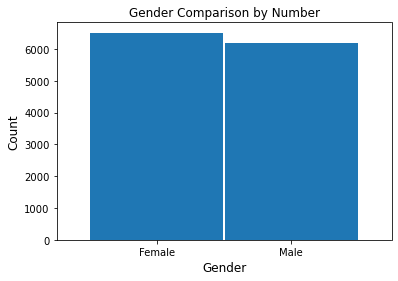

Female    6511
Male      6173
Name: gender, dtype: int64

In [18]:
gender_count = coupons_df['gender'].value_counts()
fig = plt.figure()
gender_count.plot.bar(x ='lab', y='val', rot=0, width=0.99)
plt.title ('Gender Comparison by Number', fontsize=12)
plt.xlabel('Gender', fontsize=12) 
plt.ylabel('Count', fontsize=12)
plt.show()
gender_count

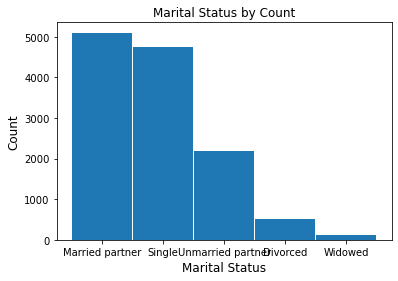

Married partner      5100
Single               4752
Unmarried partner    2186
Divorced              516
Widowed               130
Name: maritalStatus, dtype: int64

In [19]:
marital_coupons = coupons_df['maritalStatus'].value_counts()
fig = plt.figure()
marital_coupons.plot.bar(x ='lab', y='val', rot=0, width=0.98)
plt.title ('Marital Status by Count', fontsize=12)
plt.xlabel('Marital Status', fontsize=12) 
plt.ylabel('Count', fontsize=12)
plt.show()
marital_coupons

In [20]:
print("\033[1m"+'Coupon Summary Statistics:'+"\033[1m")

def coupon_summary_stats():
    pd.options.display.float_format = '{:,.2f}'.format
    coupon_summary = pd.DataFrame(coupons_df).describe().transpose()
    cols_to_keep = ['mean', 'std', 'min', '25%', '50%','75%', 'max']
    coupon_summary = coupon_summary[cols_to_keep]
    stats_rename = coupon_summary.rename(columns={'count':'Count','min':'Minimum',
                                '25%':'Q1','50%':'Median','mean':'Mean','75%':
                                'Q3','std': 'Standard Deviation','max':'Maximum'})
    return stats_rename

coupon_summary_stats()

Coupon Summary Statistics:


,Mean,Standard Deviation,Minimum,Q1,Median,Q3,Maximum
temperature,63.30,19.15,30.00,55.00,80.00,80.00,80.00
time,13.82,5.41,7.00,10.00,14.00,18.00,22.00
expiration,14.30,10.92,2.00,2.00,24.00,24.00,24.00
has_children,0.41,0.49,0.00,0.00,0.00,1.00,1.00
toCoupon_GEQ5min,1.00,0.00,1.00,1.00,1.00,1.00,1.00
toCoupon_GEQ15min,0.56,0.50,0.00,0.00,1.00,1.00,1.00
toCoupon_GEQ25min,0.12,0.32,0.00,0.00,0.00,0.00,1.00
direction_same,0.21,0.41,0.00,0.00,0.00,0.00,1.00
direction_opp,0.79,0.41,0.00,1.00,1.00,1.00,1.00
Response,0.57,0.50,0.00,0.00,1.00,1.00,1.00


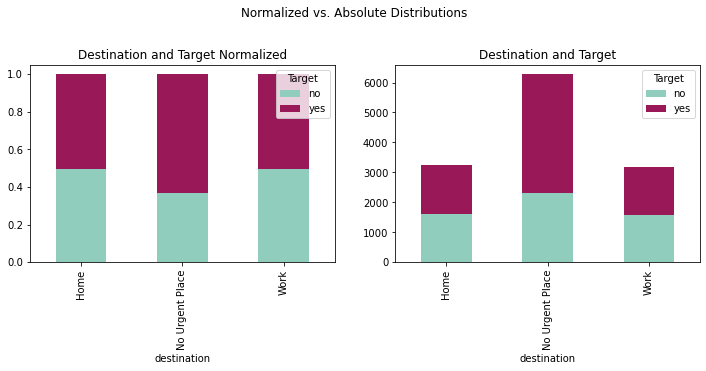

In [21]:
fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(221); ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabdest = pd.crosstab(coupons_df['destination'], coupons_df['Target'])
crosstabdestnorm = crosstabdest.div(crosstabdest.sum(1), axis=0)

plotdest = crosstabdest.plot(kind='bar', 
                             stacked=True, 
                             title='Destination and Target', 
                             ax=ax1, 
                             color=['#90CDBC', '#991857'])

plotdestnorm = crosstabdestnorm.plot(kind='bar', 
                                     stacked=True, 
                                     title='Destination and Target Normalized', 
                                     ax=ax2, 
                                     color=['#90CDBC', '#991857'])

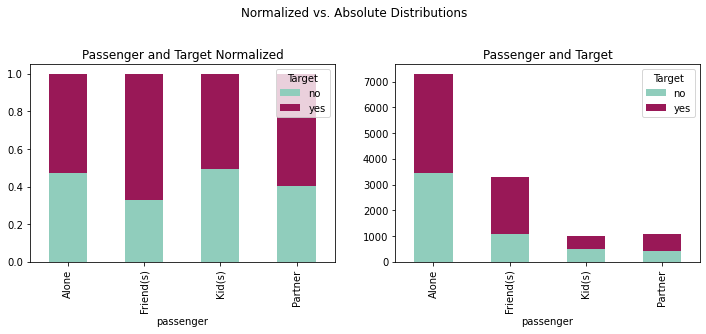

In [22]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221); ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabpass = pd.crosstab(coupons_df['passenger'],coupons_df['Target'])
crosstabpassnorm = crosstabpass.div(crosstabpass.sum(1), axis = 0)
plotpass = crosstabpass.plot(kind='bar', stacked = True, 
                             title = 'Passenger and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])
plotpassnorm = crosstabpassnorm.plot(kind='bar', stacked = True, 
                                     title = 'Passenger and Target Normalized', 
                                     ax = ax2, color = ['#90CDBC', '#991857'])

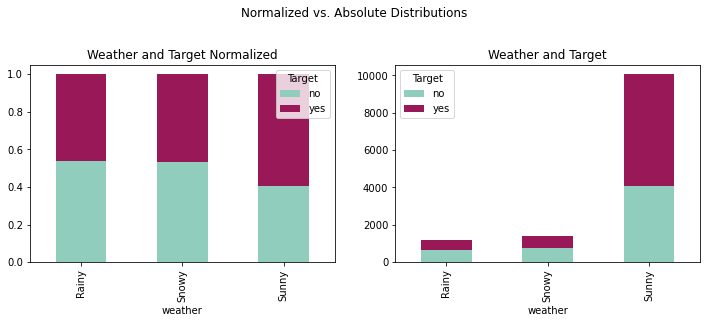

In [23]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabweat = pd.crosstab(coupons_df['weather'],coupons_df['Target'])
crosstabweatnorm = crosstabweat.div(crosstabweat.sum(1), axis=0)

plotweat = crosstabweat.plot(kind='bar', stacked = True, 
                             title='Weather and Target', 
                             ax=ax1, color=['#90CDBC', '#991857'])

plotweatnorm = crosstabweatnorm.plot(kind='bar', stacked = True, 
                                     title='Weather and Target Normalized', 
                                     ax=ax2, color=['#90CDBC', '#991857'])

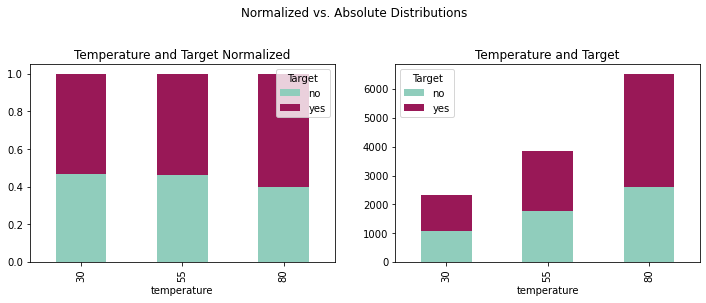

In [24]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabtemp = pd.crosstab(coupons_df['temperature'],coupons_df['Target'])
crosstabtempnorm = crosstabtemp.div(crosstabtemp.sum(1), axis = 0)

plottemp = crosstabtemp.plot(kind='bar', stacked = True, 
                             title = 'Temperature and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])

plottempnorm = crosstabtempnorm.plot(kind='bar', stacked = True, 
                                     title = 'Temperature and Target Normalized', 
                                     ax = ax2, color = ['#90CDBC', '#991857'])

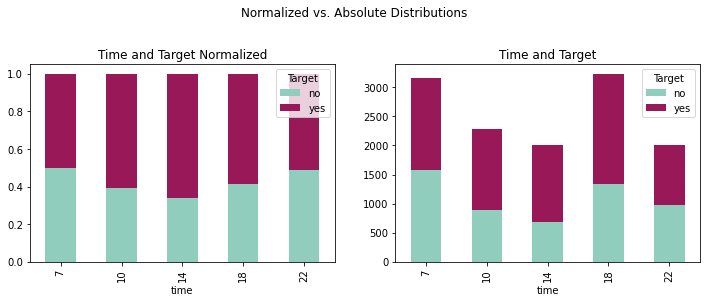

In [25]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabtime = pd.crosstab(coupons_df['time'],coupons_df['Target'])
crosstabtimenorm = crosstabtime.div(crosstabtime.sum(1), axis = 0)

plottime = crosstabtime.plot(kind='bar', 
                             stacked=True, 
                             title='Time and Target', 
                             ax=ax1, 
                             color=['#90CDBC', '#991857'])
plottimenorm = crosstabtimenorm.plot(kind='bar', 
                                     stacked=True, 
                                     title='Time and Target Normalized', 
                                     ax=ax2, 
                                     color=['#90CDBC', '#991857'])

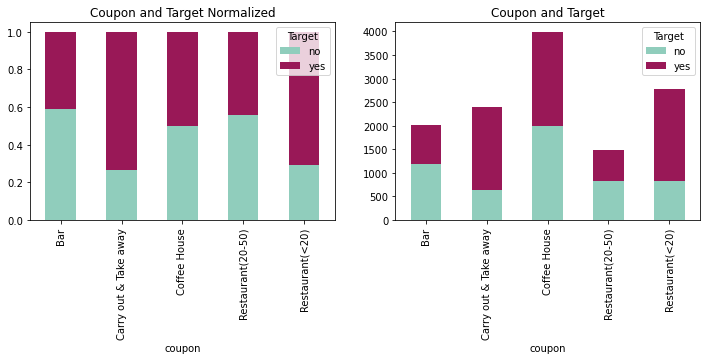

In [26]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
# fig.suptitle('Normalized vs. Absolute Distributions')

crosstabcoup = pd.crosstab(coupons_df['coupon'],coupons_df['Target'])
crosstabcoupnorm = crosstabcoup.div(crosstabcoup.sum(1), axis = 0)

plotcoup = crosstabcoup.plot(kind='bar', stacked = True, 
                             title = 'Coupon and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])

plotcoupnorm = crosstabcoupnorm.plot(kind='bar', stacked = True, 
                                     title = 'Coupon and Target Normalized', 
                                     ax = ax2, color = ['#90CDBC', '#991857'])

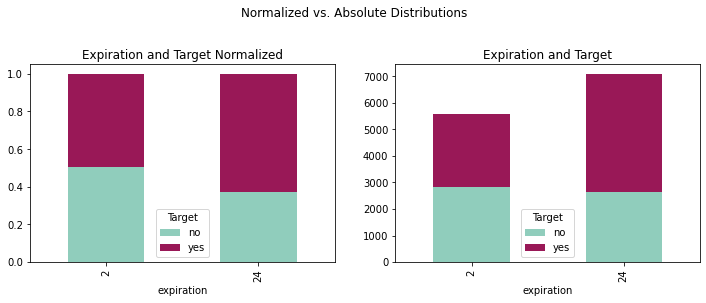

In [27]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221); ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabexpi = pd.crosstab(coupons_df['expiration'],coupons_df['Target'])
crosstabexpinorm = crosstabexpi.div(crosstabexpi.sum(1), axis = 0)
plotexpi = crosstabexpi.plot(kind='bar', stacked = True, 
                             title = 'Expiration and Target', ax = ax1, 
                             color = ['#90CDBC', '#991857'])
plotexpinorm = crosstabexpinorm.plot(kind='bar', stacked = True, 
                                     title = 'Expiration and Target Normalized', 
                                     ax = ax2, color = ['#90CDBC', '#991857'])

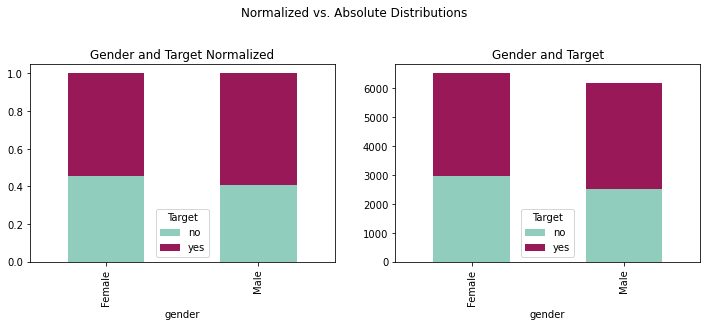

In [28]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabgender = pd.crosstab(coupons_df['gender'],coupons_df['Target'])
crosstabgendernorm = crosstabgender.div(crosstabgender.sum(1), axis = 0)

plotgender = crosstabgender.plot(kind='bar', stacked = True, 
                                 title = 'Gender and Target', 
                                 ax = ax1, color = ['#90CDBC', '#991857'])


plotgendernorm = crosstabgendernorm.plot(kind='bar', stacked = True, 
                                         title = 'Gender and Target Normalized', 
                                         ax = ax2, color = ['#90CDBC', '#991857'])

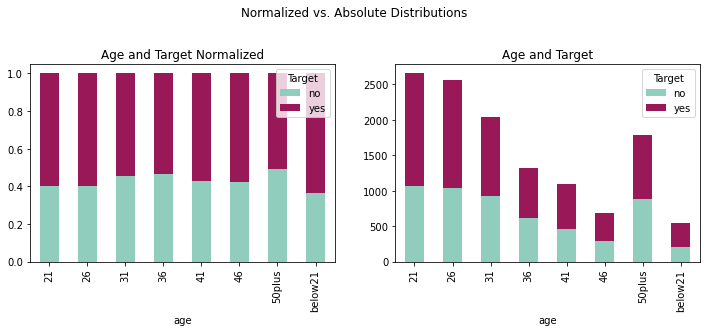

In [29]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabage = pd.crosstab(coupons_df['age'],coupons_df['Target'])
crosstabagenorm = crosstabage.div(crosstabage.sum(1), axis = 0)

plotage = crosstabage.plot(kind='bar', stacked = True, 
                           title = 'Age and Target', ax = ax1, 
                           color = ['#90CDBC', '#991857'])


plotagenorm = crosstabagenorm.plot(kind='bar', stacked = True, 
                                   title = 'Age and Target Normalized', 
                                   ax = ax2, color = ['#90CDBC', '#991857'])

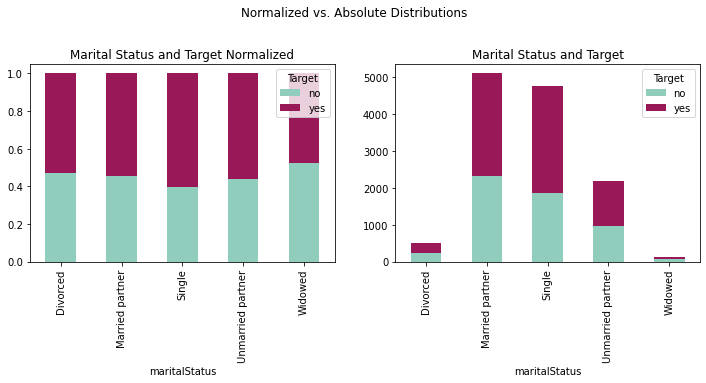

In [30]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221); ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabmari = pd.crosstab(coupons_df['maritalStatus'],coupons_df['Target'])
crosstabmarinorm = crosstabmari.div(crosstabmari.sum(1), axis=0)
plotmari = crosstabmari.plot(kind='bar', stacked=True, 
                             title='Marital Status and Target', 
                             ax=ax1, color=['#90CDBC', '#991857'])

plotmarinorm = crosstabmarinorm.plot(kind='bar', stacked = True, 
                                     title='Marital Status and Target Normalized', 
                                     ax=ax2, color=['#90CDBC', '#991857'])

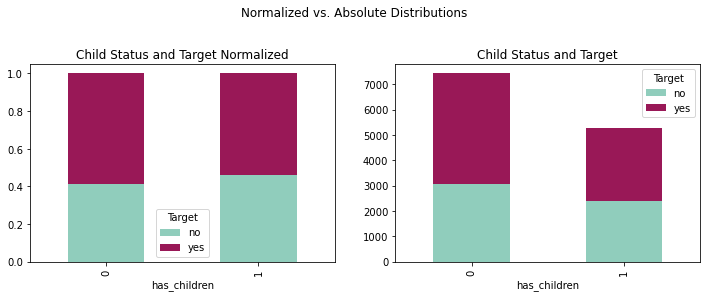

In [31]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221); ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')
crosstabchild = pd.crosstab(coupons_df['has_children'],
                            coupons_df['Target'])
crosstabchildnorm = crosstabchild.div(crosstabchild.sum(1), axis=0)

plotchild = crosstabchild.plot(kind='bar', stacked=True, 
                               title='Child Status and Target', 
                               ax=ax1, color=['#90CDBC', '#991857'])

plotchildnorm = crosstabchildnorm.plot(kind='bar', stacked=True, 
                                       title='Child Status and Target Normalized', 
                                       ax=ax2, color=['#90CDBC', '#991857'])

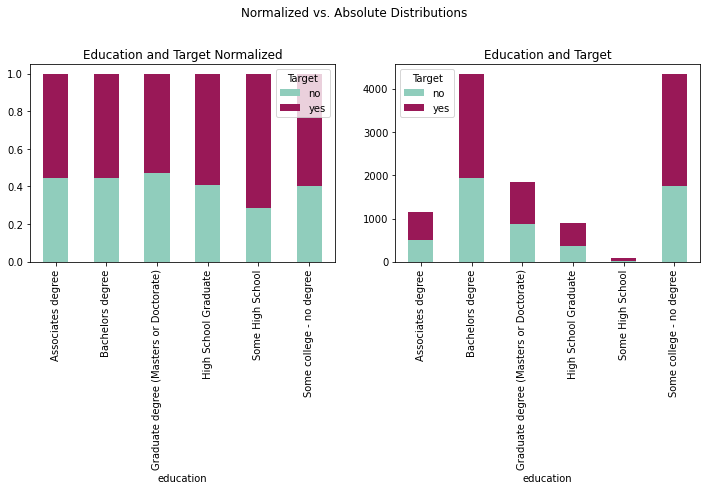

In [32]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabeduc = pd.crosstab(coupons_df['education'],coupons_df['Target'])
crosstabeducnorm = crosstabeduc.div(crosstabeduc.sum(1), axis = 0)

ploteduc = crosstabeduc.plot(kind='bar', stacked = True, 
                             title = 'Education and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])


ploteducnorm = crosstabeducnorm.plot(kind='bar', stacked = True, 
                                     title = 'Education and Target Normalized', 
                                     ax = ax2, color = ['#90CDBC', '#991857'])

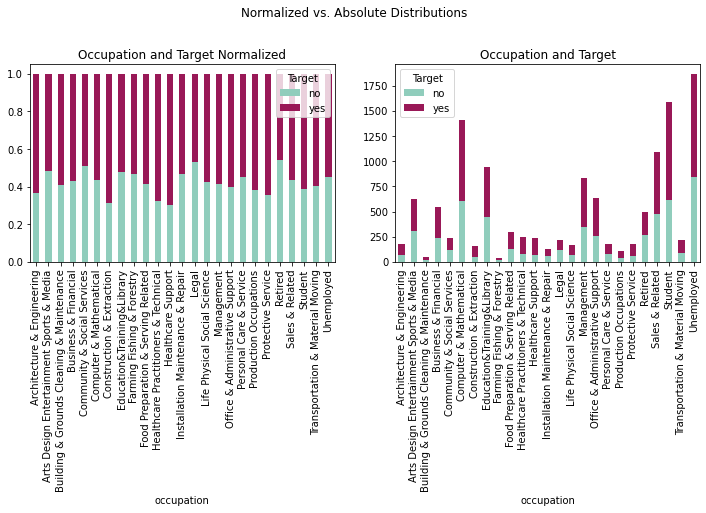

In [33]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstaboccu = pd.crosstab(coupons_df['occupation'],coupons_df['Target'])
crosstaboccunorm = crosstaboccu.div(crosstaboccu.sum(1), axis = 0)

plotoccu = crosstaboccu.plot(kind='bar', stacked = True, 
                             title = 'Occupation and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])


plotoccunorm = crosstaboccunorm.plot(kind='bar', stacked = True, 
                                     title = 'Occupation and Target Normalized', 
                                     ax = ax2, color = ['#90CDBC', '#991857'])

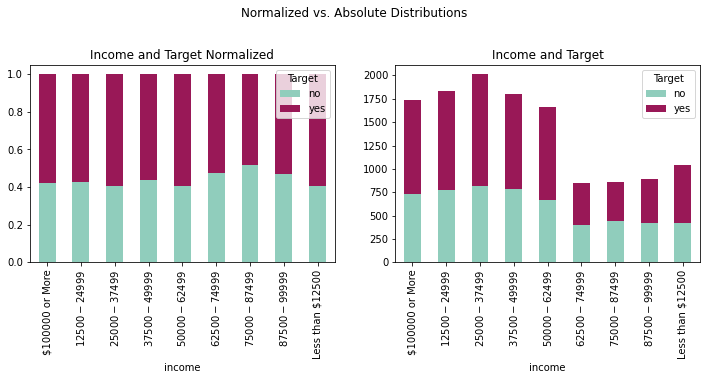

In [34]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)

fig.suptitle('Normalized vs. Absolute Distributions')

crosstabinco = pd.crosstab(coupons_df['income'],
                           coupons_df['Target'])

crosstabinconorm = crosstabinco.div(crosstabinco.sum(1), axis = 0)

plotinco = crosstabinco.plot(kind='bar', stacked = True, 
                             title = 'Income and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])


plotinconorm = crosstabinconorm.plot(kind='bar', stacked = True, 
                                     title = 'Income and Target Normalized', 
                                     ax = ax2, color = ['#90CDBC', '#991857'])

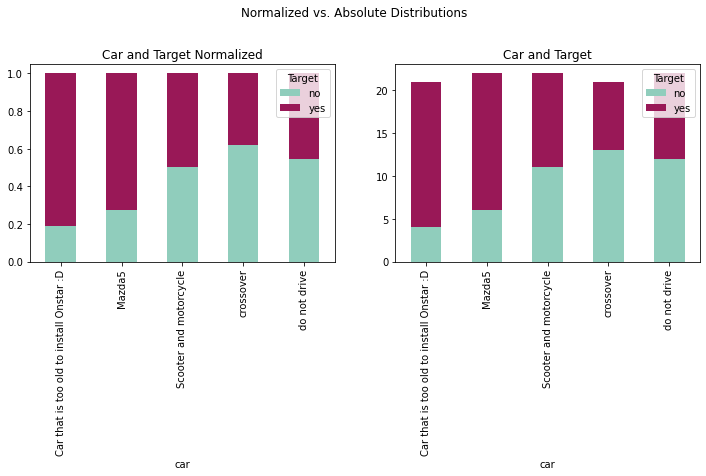

In [35]:
fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)

fig.suptitle('Normalized vs. Absolute Distributions')

crosstabcar = pd.crosstab(coupons_df['car'],coupons_df['Target'])
crosstabcarnorm = crosstabcar.div(crosstabcar.sum(1), 
                                  axis = 0)

plotcar = crosstabcar.plot(kind='bar', 
                           stacked=True, 
                           title='Car and Target', 
                           ax=ax1, 
                           color=['#90CDBC', '#991857'])


plotcarnorm = crosstabcarnorm.plot(kind='bar', 
                                   stacked=True,
                                   title='Car and Target Normalized', 
                                   ax=ax2, 
                                   color=['#90CDBC', 
                                          '#991857'])


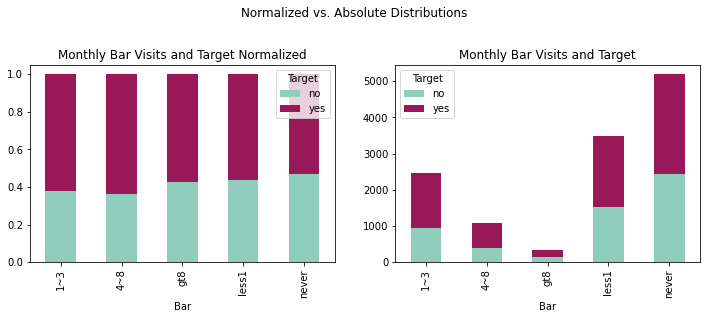

In [36]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)

fig.suptitle('Normalized vs. Absolute Distributions')

crosstabbar = pd.crosstab(coupons_df['Bar'], coupons_df['Target'])
crosstabbarnorm = crosstabbar.div(crosstabbar.sum(1), 
                                  axis=0)

plotbar = crosstabbar.plot(kind='bar', 
                           stacked=True, 
                           title='Monthly Bar Visits and Target', 
                           ax=ax1, 
                           color=['#90CDBC', 
                                  '#991857'])


plotbarnorm = crosstabbarnorm.plot(kind='bar', stacked = True, 
                                   title='Monthly Bar Visits and Target ' +
                                         'Normalized', 
                                   ax=ax2, 
                                   color=['#90CDBC', 
                                          '#991857'])

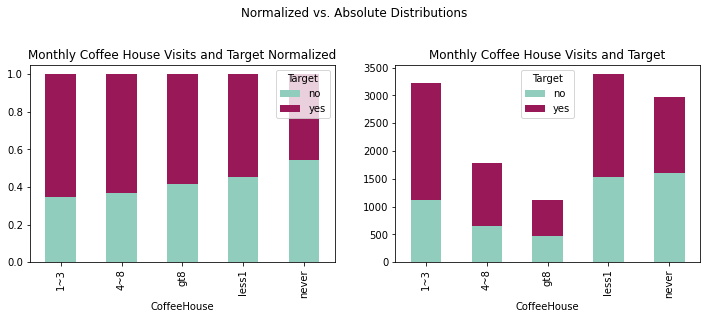

In [37]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221); ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')
crosstabcoff = pd.crosstab(coupons_df['CoffeeHouse'], coupons_df['Target'])
crosstabcoffnorm = crosstabcoff.div(crosstabcoff.sum(1), axis = 0)
plotcoff = crosstabcoff.plot(kind='bar', stacked=True, 
                             title='Monthly Coffee House Visits and Target',
                             ax=ax1, color=['#90CDBC', '#991857'])
plotcoffnorm = crosstabcoffnorm.plot(kind='bar', stacked=True, 
title = 'Monthly Coffee House Visits and Target Normalized', 
                                     ax=ax2, color=['#90CDBC', '#991857'])

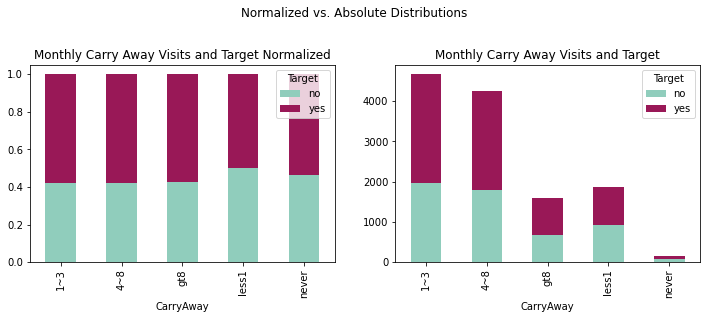

In [38]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabcarr = pd.crosstab(coupons_df['CarryAway'],coupons_df['Target'])
crosstabcarrnorm = crosstabcarr.div(crosstabcarr.sum(1), axis = 0)

plotcarr = crosstabcarr.plot(kind='bar', stacked = True, 
                             title = 'Monthly Carry Away Visits and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])

plotcarrnorm = crosstabcarrnorm.plot(kind='bar', stacked = True, 
title = 'Monthly Carry Away Visits and Target Normalized', 
                                     ax = ax2, color = ['#90CDBC', '#991857'])

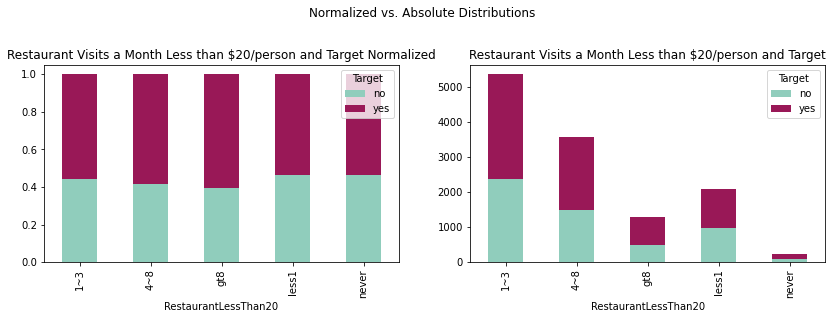

In [39]:
fig = plt.figure(figsize=(14,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabLess = pd.crosstab(coupons_df['RestaurantLessThan20'],coupons_df['Target'])
crosstabLessnorm = crosstabLess.div(crosstabLess.sum(1), axis = 0)

plotLess = crosstabLess.plot(kind='bar', stacked = True, 
title = 'Restaurant Visits a Month Less than $20/person and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])

plotLessnorm = crosstabLessnorm.plot(kind='bar', stacked = True, 
title = 'Restaurant Visits a Month Less than $20/person and Target Normalized', 
                                     ax = ax2, color = ['#90CDBC', '#991857'])

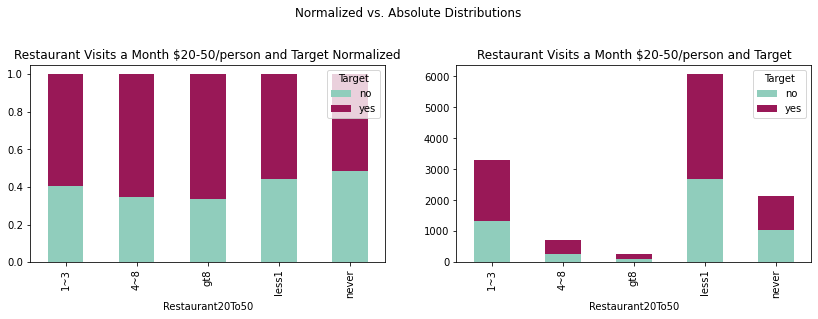

In [40]:
fig = plt.figure(figsize=(14,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabTo50 = pd.crosstab(coupons_df['Restaurant20To50'],coupons_df['Target'])
crosstabTo50norm = crosstabTo50.div(crosstabTo50.sum(1), axis = 0)

plotTo50 = crosstabTo50.plot(kind='bar', stacked = True, 
title = 'Restaurant Visits a Month $20-50/person and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])

plotTo50norm = crosstabTo50norm.plot(kind='bar', stacked = True,
title = 'Restaurant Visits a Month $20-50/person and Target Normalized',
                                     ax = ax2, color = ['#90CDBC', '#991857'])

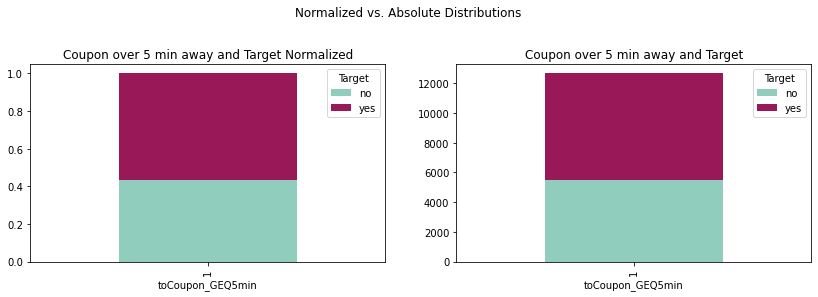

In [41]:
fig = plt.figure(figsize=(14,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstab5min = pd.crosstab(coupons_df['toCoupon_GEQ5min'],coupons_df['Target'])
crosstab5minnorm = crosstab5min.div(crosstab5min.sum(1), axis = 0)

plot5min = crosstab5min.plot(kind='bar', stacked = True, 
                             title = 'Coupon over 5 min away and Target', 
                             ax = ax1, color = ['#90CDBC', '#991857'])


plot5minnorm = crosstab5minnorm.plot(kind='bar', stacked = True, 
title = 'Coupon over 5 min away and Target Normalized', 
                             ax = ax2, color = ['#90CDBC', '#991857'])

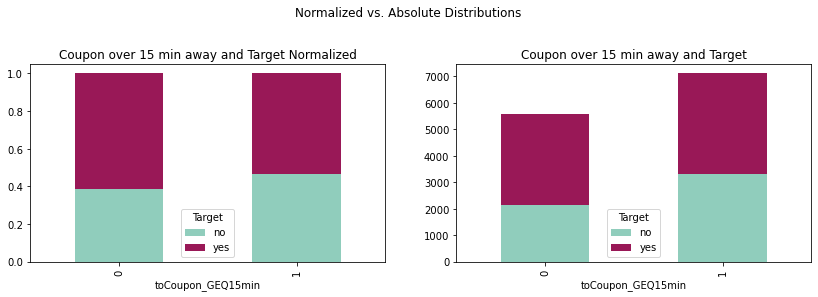

In [42]:
fig = plt.figure(figsize=(14,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstab15min = pd.crosstab(coupons_df['toCoupon_GEQ15min'],
                            coupons_df['Target'])
crosstab15minnorm = crosstab15min.div(crosstab15min.sum(1), 
                                      axis = 0)

plot15min = crosstab15min.plot(kind='bar', 
                               stacked = True, 
title = 'Coupon over 15 min away and Target',
                               ax = ax1, 
                               color = ['#90CDBC', '#991857'])

plot15minnorm = crosstab15minnorm.plot(kind='bar', 
                                       stacked = True, 
title = 'Coupon over 15 min away and Target Normalized', 
                                       ax = ax2, 
                                       color = ['#90CDBC', '#991857'])

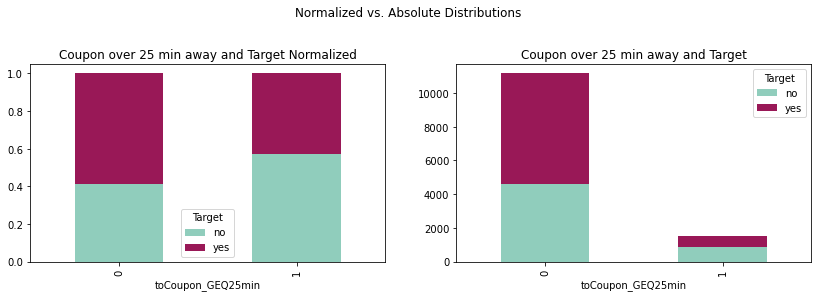

In [43]:
fig = plt.figure(figsize=(14,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstab25min = pd.crosstab(coupons_df['toCoupon_GEQ25min'],coupons_df['Target'])
crosstab25minnorm = crosstab25min.div(crosstab25min.sum(1), axis = 0)

plot25min = crosstab25min.plot(kind='bar', stacked = True, 
title = 'Coupon over 25 min away and Target', 
                               ax = ax1, color = ['#90CDBC', '#991857'])


plot25minnorm = crosstab25minnorm.plot(kind='bar', stacked = True,
title = 'Coupon over 25 min away and Target Normalized', 
                                       ax = ax2, color = ['#90CDBC', '#991857'])

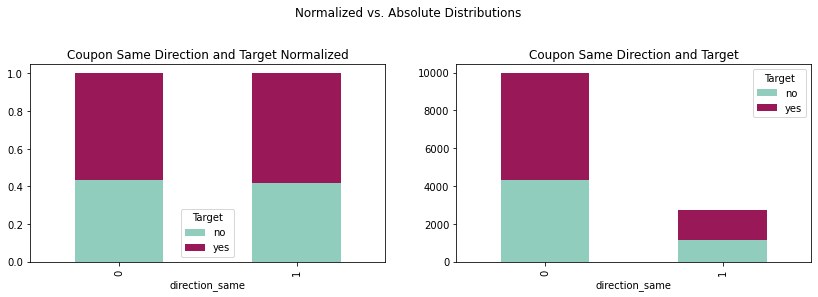

In [44]:
fig = plt.figure(figsize=(14,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)

fig.suptitle('Normalized vs. Absolute Distributions')

crosstabsame = pd.crosstab(coupons_df['direction_same'],
                           coupons_df['Target'])
crosstabsamenorm = crosstabsame.div(crosstabsame.sum(1), 
                                    axis = 0)

plotsame = crosstabsame.plot(kind='bar', 
                             stacked = True, 
title = 'Coupon Same Direction and Target', 
                             ax = ax1, 
                             color = ['#90CDBC', '#991857'])

plotsamenorm = crosstabsamenorm.plot(kind='bar', 
                                     stacked = True, 
title = 'Coupon Same Direction and Target Normalized', 
                                     ax = ax2, 
                                     color = ['#90CDBC', '#991857'])


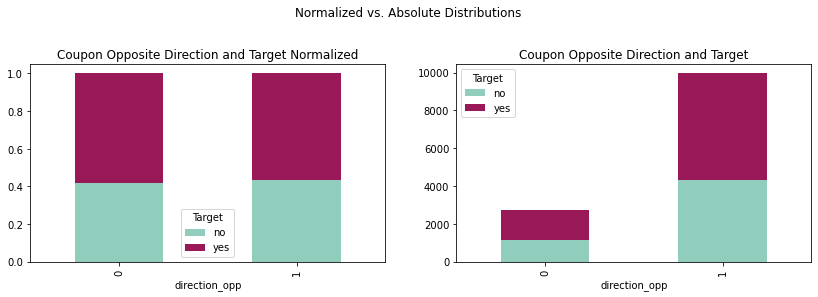

In [45]:
fig = plt.figure(figsize=(14,8))
ax2 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
fig.suptitle('Normalized vs. Absolute Distributions')

crosstabopp = pd.crosstab(coupons_df['direction_opp'],coupons_df['Target'])
crosstaboppnorm = crosstabopp.div(crosstabopp.sum(1), axis = 0)

plotopp = crosstabopp.plot(kind='bar', stacked = True, 
title = 'Coupon Opposite Direction and Target', 
                           ax = ax1, color = ['#90CDBC', '#991857'])


plotoppnorm = crosstaboppnorm.plot(kind='bar', stacked = True, 
title = 'Coupon Opposite Direction and Target Normalized', 
                                   ax = ax2, color = ['#90CDBC', '#991857'])

**Dropping Unnecessary Columns**

With a 99.15% missing percentage, any imputation method would be impractical and the variable car will be dropped

Since 'toCoupon_GEQ5min Column' is a constant feature, we remove it.

Since 'direction_opp' is a highly correlated variable, it is dropped as well.

In [46]:
coupons_df.drop(columns=['car'], inplace=True)

In [47]:
coupons_df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

In [48]:
coupons_df.drop(columns=['direction_opp'], inplace=True)

### Examining Correlations

In [49]:
corr = coupons_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,temperature,time,expiration,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Response,educ. level,avg_income,Age Group,ages
temperature,1.000000,-0.044991,-0.124090,-0.019716,-0.155332,-0.216254,0.097085,0.061240,0.010532,-0.031994,-0.019437,-0.019034
time,-0.044991,1.000000,-0.027313,0.026965,-0.061299,-0.188325,0.002614,0.010271,0.016343,0.011600,0.006095,0.004206
expiration,-0.124090,-0.027313,1.000000,-0.016020,-0.042740,0.032977,-0.033584,0.129920,-0.006204,-0.019975,-0.022698,-0.017577
has_children,-0.019716,0.026965,-0.016020,1.000000,0.078211,-0.013722,-0.031620,-0.045557,0.080869,0.091126,0.464277,0.394646
toCoupon_GEQ15min,-0.155332,-0.061299,-0.042740,0.078211,1.000000,0.324984,-0.303533,-0.081602,0.019568,0.020621,0.037836,0.031048
toCoupon_GEQ25min,-0.216254,-0.188325,0.032977,-0.013722,0.324984,1.000000,-0.192319,-0.103633,0.012240,-0.006420,-0.003661,-0.000119
direction_same,0.097085,0.002614,-0.033584,-0.031620,-0.303533,-0.192319,1.000000,0.014570,0.011606,-0.023558,-0.031210,-0.025054
Response,0.061240,0.010271,0.129920,-0.045557,-0.081602,-0.103633,0.014570,1.000000,-0.040362,-0.029082,-0.059060,-0.058243
educ. level,0.010532,0.016343,-0.006204,0.080869,0.019568,0.012240,0.011606,-0.040362,1.000000,0.119764,0.197270,0.161348
avg_income,-0.031994,0.011600,-0.019975,0.091126,0.020621,-0.006420,-0.023558,-0.029082,0.119764,1.000000,0.101300,0.046381


# Evaluation of Imputation Methods

The variables Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, have a low null count $ < 2\%$. We will evaluate different imputation methods that best preserves the distribution of the data.


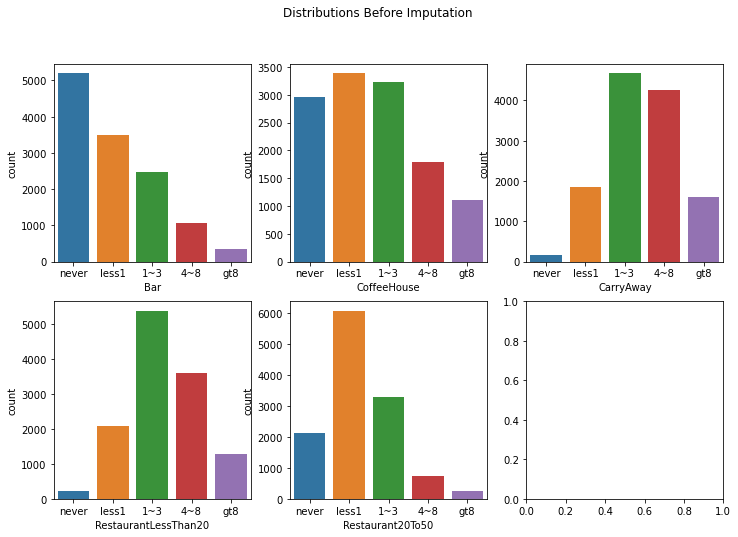

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

likert_vals = ['never', 'less1', '1~3', '4~8', 'gt8']

fig.suptitle('Distributions Before Imputation')
sns.countplot(ax=axes[0, 0], data=coupons_df,
              x="Bar", order=likert_vals)
sns.countplot(ax=axes[0, 1], data=coupons_df, 
              x="CoffeeHouse", order=likert_vals)
sns.countplot(ax=axes[0, 2], data=coupons_df, 
              x="CarryAway", order=likert_vals)
sns.countplot(ax=axes[1, 0], data=coupons_df, 
              x="RestaurantLessThan20", order=likert_vals)
sns.countplot(ax=axes[1, 1], data=coupons_df, 
              x="Restaurant20To50", order=likert_vals)
plt.show()

## KL Divergence

The Kullback-Leibler Divergence will be used to determine the amount the distribution of each variable diverges after imputation. The imputation method with the smallest KL divergence will be selected.

$$ D_{KL}(P||Q) = \Large\sum_{i}\normalsize P(i) \normalsize\text{log}\frac{P(i)}{Q(i)}$$

$$ D_{KL}(P||Q) = \Large \int \normalsize P(x) \normalsize\text{log}\frac{P(x)}{Q(x)} dx$$ 

In [51]:
def kl_divergence(p, q):
    return sum(p * np.log(p/q))

## Imputation Methods
  * Median Imputation
  * Frequent Imputation

The values of the variables Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, appear to be values from a likert scale. These are ordinal values, so they will be converted accordingly, before median imputation can be used.

In [52]:
impute_test = coupons_df[['Bar', 'CoffeeHouse', 'CarryAway', 
                         'RestaurantLessThan20', 'Restaurant20To50']]
impute_test.replace({'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4}, 
                    inplace=True)
# Store KL results
cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 
        'Restaurant20To50']
kl_results = pd.DataFrame(index=cols)

**Median Imputation**


In [53]:
med_impute = SimpleImputer(missing_values=np.nan, strategy='median')
med_impute_df = pd.DataFrame(med_impute.fit_transform(impute_test), 
                             columns=['Bar', 'CoffeeHouse', 'CarryAway', 
                                      'RestaurantLessThan20', 'Restaurant20To50'])

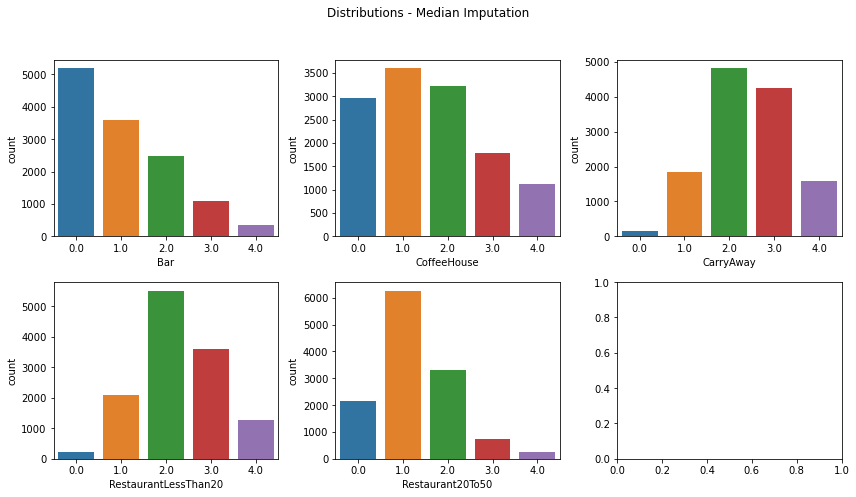

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('Distributions - Median Imputation')
sns.countplot(ax=axes[0, 0], data=med_impute_df, x="Bar")
sns.countplot(ax=axes[0, 1], data=med_impute_df, x="CoffeeHouse")
sns.countplot(ax=axes[0, 2], data=med_impute_df, x="CarryAway")
sns.countplot(ax=axes[1, 0], data=med_impute_df, x="RestaurantLessThan20")
sns.countplot(ax=axes[1, 1], data=med_impute_df, x="Restaurant20To50")
plt.tight_layout(rect=[0, 0, 1, 0.9]); plt.show()

In [55]:
med_results = []
for col in cols:
    p = impute_test[col].dropna()
    p = p.groupby(p).count() / p.shape[0]
    q = med_impute_df[col].groupby(med_impute_df[col]).count() / \
      med_impute_df[col].shape[0]

    print('P(%s = x) = %s' % (col, p.to_list()))
    print('Q(%s = x) = %s' % (col, q.to_list()))
    print('KL Divergence: %f' % kl_divergence(p, q))
    print('\n')
    med_results.append(kl_divergence(p, q))
kl_results['Median Imputation'] = med_results
  


P(Bar = x) = [0.41321459807585276, 0.27685457581299194, 0.19662876679653335, 0.08555299355967241, 0.027749065754949512]
Q(Bar = x) = [0.4097287921791233, 0.282954903815831, 0.19497004099653106, 0.0848312835067802, 0.02751497950173447]
KL Divergence: 0.000092


P(CoffeeHouse = x) = [0.23758723028796022, 0.2715168043635197, 0.2586829229164996, 0.1430977781342745, 0.08911526429774605]
Q(CoffeeHouse = x) = [0.2335225480920845, 0.2839798170923999, 0.2542573320719016, 0.14064963733837907, 0.08759066540523494]
KL Divergence: 0.000385


P(CarryAway = x) = [0.01220777148328413, 0.14808904492140748, 0.3727758716987154, 0.3397430782733583, 0.12718423362323467]
Q(CarryAway = x) = [0.012062440870387891, 0.14632608010091455, 0.380242825607064, 0.33569851781772314, 0.12567013560391044]
KL Divergence: 0.000119


P(RestaurantLessThan20 = x) = [0.017524295045403857, 0.16671977059104667, 0.4282300462004142, 0.28516807392066273, 0.10235781424247252]
Q(RestaurantLessThan20 = x) = [0.017344686218858405, 0.1

**Frequent Imputation**

In [56]:
freq_impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
freq_impute_df = pd.DataFrame(freq_impute.fit_transform(impute_test), 
                              columns=['Bar', 'CoffeeHouse', 'CarryAway', 
                                       'RestaurantLessThan20', 'Restaurant20To50'])

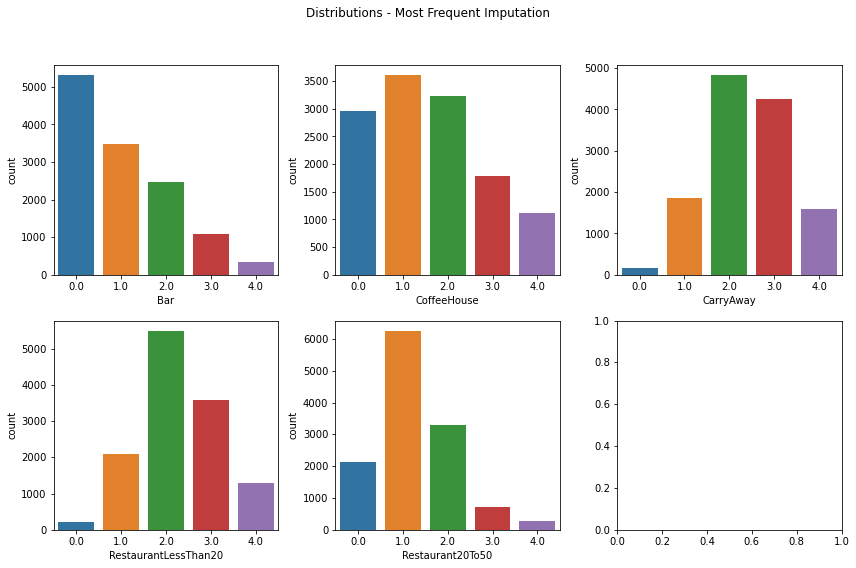

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
  
fig.suptitle('Distributions - Most Frequent Imputation')
sns.countplot(ax=axes[0, 0], data=freq_impute_df, x="Bar")
sns.countplot(ax=axes[0, 1], data=freq_impute_df, x="CoffeeHouse")
sns.countplot(ax=axes[0, 2], data=freq_impute_df, x="CarryAway")
sns.countplot(ax=axes[1, 0], data=freq_impute_df, x="RestaurantLessThan20")
sns.countplot(ax=axes[1, 1], data=freq_impute_df, x="Restaurant20To50")
plt.tight_layout(rect=[0, 0, 1, 0.9]); plt.show()

In [58]:
freq_results = []
for col in cols:
    p = impute_test[col].dropna()
    p = p.groupby(p).count() / p.shape[0]
    q = freq_impute_df[col].groupby(freq_impute_df[col]).count() / \
    freq_impute_df[col].shape[0]

    print('P(%s = x) = %s' % (col, p.to_list()))
    print('Q(%s = x) = %s' % (col, q.to_list()))
    print('KL Divergence: %f' % kl_divergence(p, q))
    print('\n')
    freq_results.append(kl_divergence(p, q))
kl_results['Frequent Imputation'] = freq_results

P(Bar = x) = [0.41321459807585276, 0.27685457581299194, 0.19662876679653335, 0.08555299355967241, 0.027749065754949512]
Q(Bar = x) = [0.4181646168401135, 0.27451907915484075, 0.19497004099653106, 0.0848312835067802, 0.02751497950173447]
KL Divergence: 0.000050


P(CoffeeHouse = x) = [0.23758723028796022, 0.2715168043635197, 0.2586829229164996, 0.1430977781342745, 0.08911526429774605]
Q(CoffeeHouse = x) = [0.2335225480920845, 0.2839798170923999, 0.2542573320719016, 0.14064963733837907, 0.08759066540523494]
KL Divergence: 0.000385


P(CarryAway = x) = [0.01220777148328413, 0.14808904492140748, 0.3727758716987154, 0.3397430782733583, 0.12718423362323467]
Q(CarryAway = x) = [0.012062440870387891, 0.14632608010091455, 0.380242825607064, 0.33569851781772314, 0.12567013560391044]
KL Divergence: 0.000119


P(RestaurantLessThan20 = x) = [0.017524295045403857, 0.16671977059104667, 0.4282300462004142, 0.28516807392066273, 0.10235781424247252]
Q(RestaurantLessThan20 = x) = [0.017344686218858405, 0

## KL Divergence of Imputation Methods


In [59]:
kl_results

,Median Imputation,Frequent Imputation
Bar,0.00,0.00
CoffeeHouse,0.00,0.00
CarryAway,0.00,0.00
RestaurantLessThan20,0.00,0.00
Restaurant20To50,0.00,0.00


As shown in the table above, the imputation methods are almost identical with Imputation by Most Frequent Value (Mode) having a slightly lower KL Divergence for the variable Bar. Imputation by Most Frequent Value will be used.

## Imputation by Most Frequent Value

In [60]:
# replace values of Bar, CoffeeHouse, CarryAway, 
# RestaurantLessThan20, Restaurant20To50 as ordinal
coupons_df[cols] = coupons_df[cols].replace({'never': 0,
                                             'less1': 1, '1~3': 2, 
                                             '4~8': 3, 'gt8': 4})
coupons_df[cols] = SimpleImputer(missing_values=np.nan, 
                   strategy='most_frequent').fit_transform(coupons_df[cols])

In [61]:
null_vals = pd.DataFrame(coupons_df.isna().sum(), columns=['Null Count'])
null_vals['Null Percent'] = (null_vals['Null Count'] / coupons_df.shape[0]) * 100
null_vals

,Null Count,Null Percent
destination,0,0.00
passenger,0,0.00
weather,0,0.00
temperature,0,0.00
time,0,0.00
coupon,0,0.00
expiration,0,0.00
gender,0,0.00
age,0,0.00
maritalStatus,0,0.00


### Preprocessing

In [62]:
coupons_df = pd.read_csv('https://archive.ics.uci.edu/ml/\
machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv')
coupons_df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [63]:
# define columns types
nom = ['destination', 'passenger', 'weather', 'coupon', 
       'gender', 'maritalStatus', 'occupation']
bin = ['gender', 'has_children', 'toCoupon_GEQ15min', 
       'toCoupon_GEQ25min', 'direction_same']
ord = ['temperature', 'age', 'education', 'income', 
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 
       'Restaurant20To50']
num = ['time', 'expiration']
ex = ['car', 'toCoupon_GEQ5min', 'direction_opp']

In [64]:
# Convert time to 24h military time
def convert_time(x):
    if x[-2:] == "AM":
        return int(x[0:-2]) % 12
    else:
        return (int(x[0:-2]) % 12) + 12

def average_income(x):
    inc = np.array(x).astype(np.float)
    return sum(inc) / len(inc)

def pre_process(df):
    # keep original dataframe imutable
    ret = df.copy()
    
    # Drop columns
    ret.drop(columns=['car', 'toCoupon_GEQ5min', 'direction_opp'], 
             inplace=True)

    # rename values
    ret = ret.rename(columns={'passanger':'passenger'})
    ret['time'] = ret['time'].apply(convert_time)
    ret['expiration'] = ret['expiration'].map({'1d':24, '2h':2})

    # convert the following columns to ordinal values
    ord_cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 
                'Restaurant20To50']
    ret[ord_cols] = ret[ord_cols].replace({'never': 0, 'less1': 1, 
                                                 '1~3': 2, '4~8': 3, 'gt8': 4})
    
    # impute missing
    ret[ord_cols] = SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent').fit_transform(ret[ord_cols])
    
    # Changing coupon expiration to uniform # of hours
    ret['expiration'] = coupons_df['expiration'].map({'1d':24, '2h':2}) 

    # Age, Education, Income as ordinal
    ret['age'] = ret['age'].map({'below21':1, 
                                                 '21':2,'26':3,
                                                 '31':4,'36':5, 
                                                 '41':6,'46':6,
                                                 '50plus':7}) 
    ret['education'] = ret['education'].map(\
                            {'Some High School':1, 
                             'Some college - no degree':2, 
                             'Bachelors degree':3, 'Associates degree':4, 
                             'High School Graduate':5, 
                             'Graduate degree (Masters or Doctorate)':6})
    ret['average income'] = ret['income'].str.findall('(\d+)').apply(average_income)
    ret['income'].replace({'Less than $12500': 1, '$12500 - $24999': 2, 
                           '$25000 - $37499': 3, '$37500 - $49999': 4, 
                           '$50000 - $62499': 5, '$62500 - $74999': 6,
                           '$75000 - $87499': 7, '$87500 - $99999': 8,
                           '$100000 or More': 9}, inplace=True)

    # Change gender to binary value
    ret['gender'].replace({'Male': 0, 'Female': 1}, inplace=True)
    
    # One Hot Encode
    nom = ['destination', 'passenger', 'weather', 'coupon', 
           'maritalStatus', 'occupation']
    for col in nom:
        # k-1 cols from k values
        ohe_cols = pd.get_dummies(ret[col], prefix=col, drop_first=True)
        ret = pd.concat([ret, ohe_cols], axis=1)
        ret.drop(columns=[col], inplace=True)

    return ret 

In [65]:
# Simple function to prep a dataframe for a model
def scale_data(df, std, norm, pass_cols):
    """
    df: raw dataframe you want to process
    std: list of column names you want to standardize (0 mean unit variance)
    norm: list of column names you want to normalize (min-max)
    pass_cols: list of columns that do not require processing (target var, etc.)

    returns: prepped dataframe
    """
    ret = df.copy()
    # Only include columns from lists
    ret = ret[std + norm + pass_cols]
    # Standardize scaling for gaussian features
    if (isinstance(std, list)) and (len(std) > 0):
        ret[std] = StandardScaler().fit(ret[std]).transform(ret[std])
    # Normalize (min-max) [0,1] for non-gaussian features
    if (isinstance(norm, list)) and (len(norm) > 0):
        ret[norm] = Normalizer().fit(ret[norm]).transform(ret[norm])

    
    return ret

In [66]:
# Processed data (remove labels from dataset)
coupons_proc = pre_process(coupons_df.drop(columns='Y'))

# Labels
labels = coupons_df['Y']

# Standardize/Normalize
to_scale = ['average income', 'temperature', 'time', 'expiration']
coupons_proc = scale_data(coupons_proc, to_scale, [], 
list(set(coupons_proc.columns.tolist()).difference(set(to_scale))))

coupons_proc.head()

,average income,temperature,time,expiration,education,occupation_Computer & Mathematical,Bar,coupon_Carry out & Take away,occupation_Personal Care & Service,occupation_Transportation & Material Moving,...,occupation_Legal,occupation_Sales & Related,weather_Sunny,toCoupon_GEQ15min,has_children,RestaurantLessThan20,occupation_Construction & Extraction,destination_Work,occupation_Student,occupation_Management
0,-0.30,-0.43,0.03,0.89,2,0,0.00,0,0,0,...,0,0,1,0,1,3.00,0,0,0,0
1,-0.30,0.87,-0.71,-1.13,2,0,0.00,0,0,0,...,0,0,1,0,1,3.00,0,0,0,0
2,-0.30,0.87,-0.71,-1.13,2,0,0.00,1,0,0,...,0,0,1,1,1,3.00,0,0,0,0
3,-0.30,0.87,0.03,-1.13,2,0,0.00,0,0,0,...,0,0,1,1,1,3.00,0,0,0,0
4,-0.30,0.87,0.03,0.89,2,0,0.00,0,0,0,...,0,0,1,1,1,3.00,0,0,0,0


In [67]:
coupons_df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


### Selecting Predictors for Modeling

In [68]:
X = pd.DataFrame(coupons_proc[['average income', 'education', 'expiration', 
                             'age','temperature','has_children']])

## Generalized Linear Model

$$ y = \beta_0 + \beta_1x_1 +\beta_2x_2 +\cdots+\beta_px_p + \varepsilon $$

### Logistic Regression

### Link Function for Binary Response

$$ X\beta = \text{ln} \frac{\mu}{1-\mu}  $$

where $e^{\text{ln}(x)}=x$ and,

$$ \mu = \frac{e^{X\beta}}{1+e^{X\beta}} $$

### Logistic Regression - Parametric Form

$$p(y) = \frac{\text{exp}(\beta_0+\beta_1x_1+\beta_2x_2+\cdot\cdot\cdot+\beta_px_p)}{1+\text{exp}(\beta_0+\beta_1x_1+\beta_2x_2+\cdot\cdot\cdot+\beta_px_p)}  + \varepsilon$$

### Logistic Regression - Descriptive Form

$$\hat{p}(y) = \frac{\text{exp}(b_0+b_1x_1+b_2x_2+\cdot\cdot\cdot+b_px_p)}{1+\text{exp}(b_0+b_1x_1+b_2x_2+\cdot\cdot\cdot+b_px_p)}$$

$$\hat{p}(\text{coupons}) = \frac{\text{exp}(b_0+b_1(\text{average income})+b_2(\text{education})+\cdot\cdot\cdot+b_px_p))}{1+\text{exp}(b_0+b_1(\text{average income})+b_2(\text{education})+\cdot\cdot\cdot+b_px_p))}$$

In [69]:
X = sm.add_constant(X)
y = pd.DataFrame(coupons_df[['Y']])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size=0.20, random_state=42)
log_results = sm.Logit(y_train, X_train).fit()
log_results.summary()

Optimization terminated successfully.
         Current function value: 0.668916
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                10147
Model:                          Logit   Df Residuals:                    10140
Method:                           MLE   Df Model:                            6
Date:                Sat, 21 Jan 2023   Pseudo R-squ.:                 0.02038
Time:                        11:20:02   Log-Likelihood:                -6787.5
converged:                       True   LL-Null:                       -6928.7
Covariance Type:            nonrobust   LLR p-value:                 4.833e-58
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6642      0.064     10.303      0.000       0.538       0.791
average income    -0.0415      0.021     -2.020      0.043      -0.082      -0.001
education         -0.0502      0.015     -3.379      0.001      -0.079      -0.021
expiration         0.2855      0.021     13.916      0.000       0.245       0.326
age               -0.0419      0.013     -3.278      0.001      -0.067      -0.017
temperature        0.1509      0.020      7.366      0.000       0.111       0.191
has_children      -0.0753      0.047     -1.614      0.107      -0.167       0.016
==================================================================================
"""

**Whether or not an individual has children bears no statistical significance for this baseline model at a *p*-value of 0.107. Thus, we omit this predictor from this model.** 

**That being said, we will explore re-introducing these for subsequent models**

In [70]:
X = pd.DataFrame(coupons_proc[['average income', 'education', 'expiration',
                               'temperature','has_children']])

**The refined logistic regression equation becomes:**

$$\small{\hat{p}(\text{coupons}) = \frac{\text{exp}(0.0147-0.000001821(\text{average income})-0.0512(\text{education})+0.0262(\text{expiration})-0.0053(\text{age})+0.0079(\text{temperature}))}{1+\text{exp}(0.0147-0.000001821(\text{average income})-0.0512(\text{education})+0.0262(\text{expiration})-0.0053(\text{age})+0.0079(\text{temperature}))}}$$

In [71]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
pred_log = [round(num) for num in y_pred]
confusion_matrix(y_test, pred_log)

array([[ 324,  804],
       [ 231, 1178]], dtype=int64)

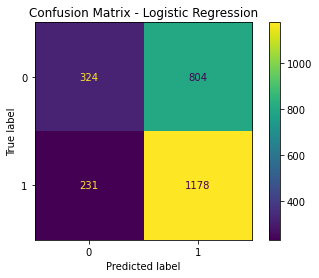

In [72]:
plot_confusion_matrix(logreg, X_test, y_test)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.29      0.39      1128
           1       0.59      0.84      0.69      1409

    accuracy                           0.59      2537
   macro avg       0.59      0.56      0.54      2537
weighted avg       0.59      0.59      0.56      2537



### Decision Tree Classifier

In [74]:
coupon_tree = tree.DecisionTreeClassifier(max_depth=3)
coupon_tree = coupon_tree.fit(X_train,y_train)

y_pred = coupon_tree.predict(X_test)

print('accuracy %2.2f ' % accuracy_score(y_test,y_pred))

accuracy 0.59 


In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.29      0.39      1128
           1       0.59      0.83      0.69      1409

    accuracy                           0.59      2537
   macro avg       0.59      0.56      0.54      2537
weighted avg       0.59      0.59      0.56      2537



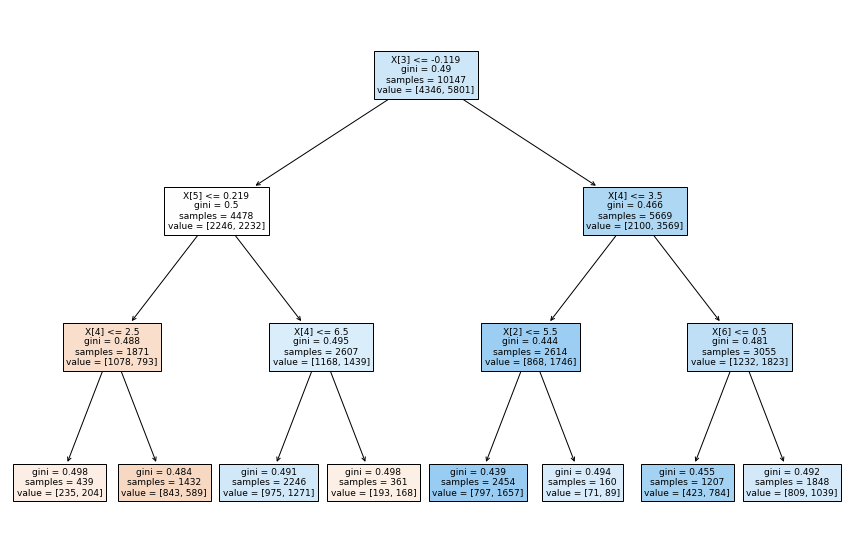

In [76]:
fig, ax = plt.subplots(figsize = (15, 10))
short_treeplot = tree.plot_tree(coupon_tree, filled=True)
plt.tight_layout(rect=[0, 0, 0, 0])
plt.show()